In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score

In [16]:
# 1. Load Cleaned Data
print("Loading data...")
df = pd.read_json("/content/cleaned_problems_data.jsonl", lines=True)

# 2. Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['cleaned_text'])
y_class = df['problem_class_encoded']
y_score = df['problem_score']

# 3. Train/Test Split
X_train, X_test, y_train_c, y_test_c, y_train_r, y_test_r = train_test_split(
    X, y_class, y_score, test_size=0.2, random_state=42, stratify=y_class)


Loading data...



--- Training Logistic Regression ---
              precision    recall  f1-score   support

        Easy       0.40      0.54      0.46       153
      Medium       0.39      0.35      0.37       281
        Hard       0.58      0.53      0.55       389

    accuracy                           0.47       823
   macro avg       0.46      0.48      0.46       823
weighted avg       0.48      0.47      0.47       823


--- Training Naive Bayes ---
              precision    recall  f1-score   support

        Easy       0.44      0.05      0.08       153
      Medium       0.40      0.16      0.23       281
        Hard       0.50      0.88      0.64       389

    accuracy                           0.48       823
   macro avg       0.44      0.36      0.32       823
weighted avg       0.45      0.48      0.40       823


--- Training SVM ---
              precision    recall  f1-score   support

        Easy       0.39      0.51      0.44       153
      Medium       0.38      0.35      

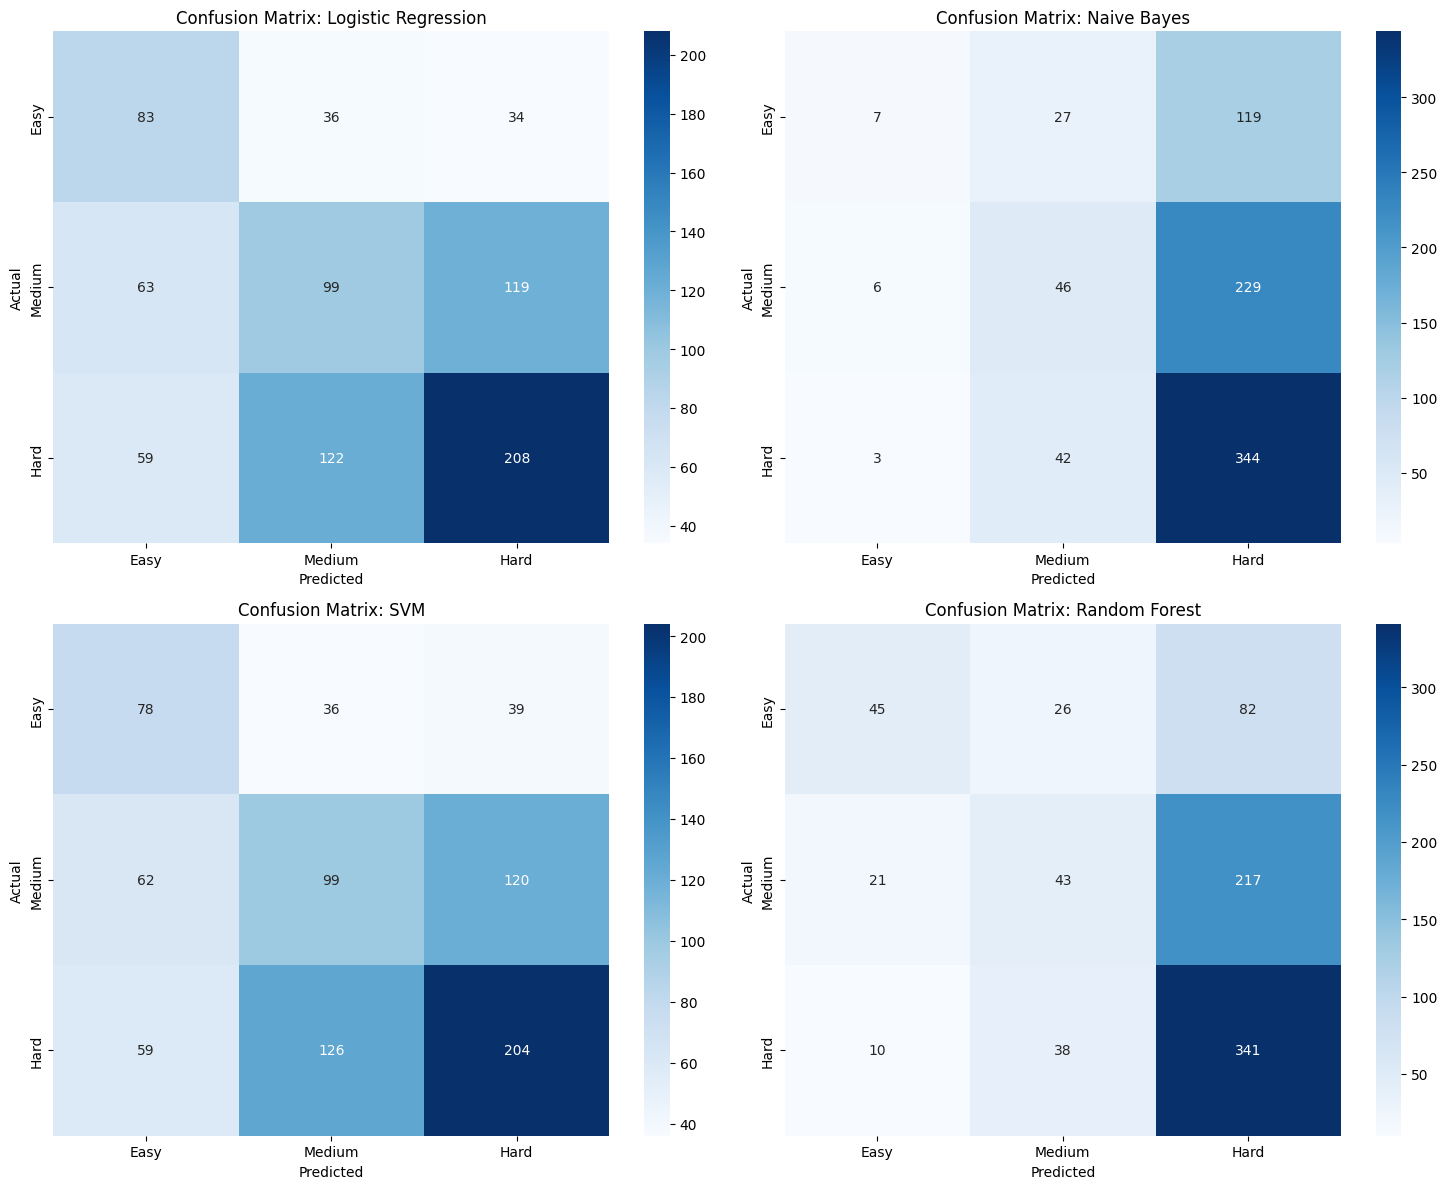

In [17]:
# --- PART 1: CLASSIFICATION TOURNAMENT ---
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear', class_weight='balanced'),
    "Random Forest":  RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
}

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, clf) in enumerate(classifiers.items()):
    print(f"\n--- Training {name} ---")
    clf.fit(X_train, y_train_c)
    y_pred = clf.predict(X_test)

    # Print Report
    print(classification_report(y_test_c, y_pred, target_names=['Easy', 'Medium', 'Hard']))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test_c, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Easy', 'Medium', 'Hard'],
                yticklabels=['Easy', 'Medium', 'Hard'])
    axes[i].set_title(f"Confusion Matrix: {name}")
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('classifier_comparison.png')
plt.show()

In [18]:
try:
    from xgboost import XGBRegressor
    has_xgboost = True
    print("✅ XGBoost is installed and ready.")
except ImportError:
    has_xgboost = False
    print("⚠️ XGBoost not found. The script will skip XGBoost and use other models.")

✅ XGBoost is installed and ready.


In [19]:
# --- PART 2: REGRESSION TOURNAMENT ---
regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}
if has_xgboost:
    regressors["XGBoost Regressor"] = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

results = []

for name, model in regressors.items():
    model.fit(X_train, y_train_r)     # 👈 train first
    preds = model.predict(X_test)  # 👈 then predict

    results.append({
        "Model": name,
        "Predictions": preds
    })

# Assuming X_test and y_test are ready
results = []
for name, model in regressors.items():
    preds = model.predict(X_test)
    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test_r, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test_r, preds)),
        "R2": r2_score(y_test_r, preds)
    })

# Convert to DataFrame for a nice display
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

                     Model       MAE      RMSE        R2
0        Linear Regression  3.996922  5.283163 -4.922913
1         Ridge Regression  1.670707  2.032469  0.123413
2  Random Forest Regressor  1.671052  1.994479  0.155876
3        Gradient Boosting  1.699593  2.031596  0.124166
4        XGBoost Regressor  1.693197  2.029365  0.126088


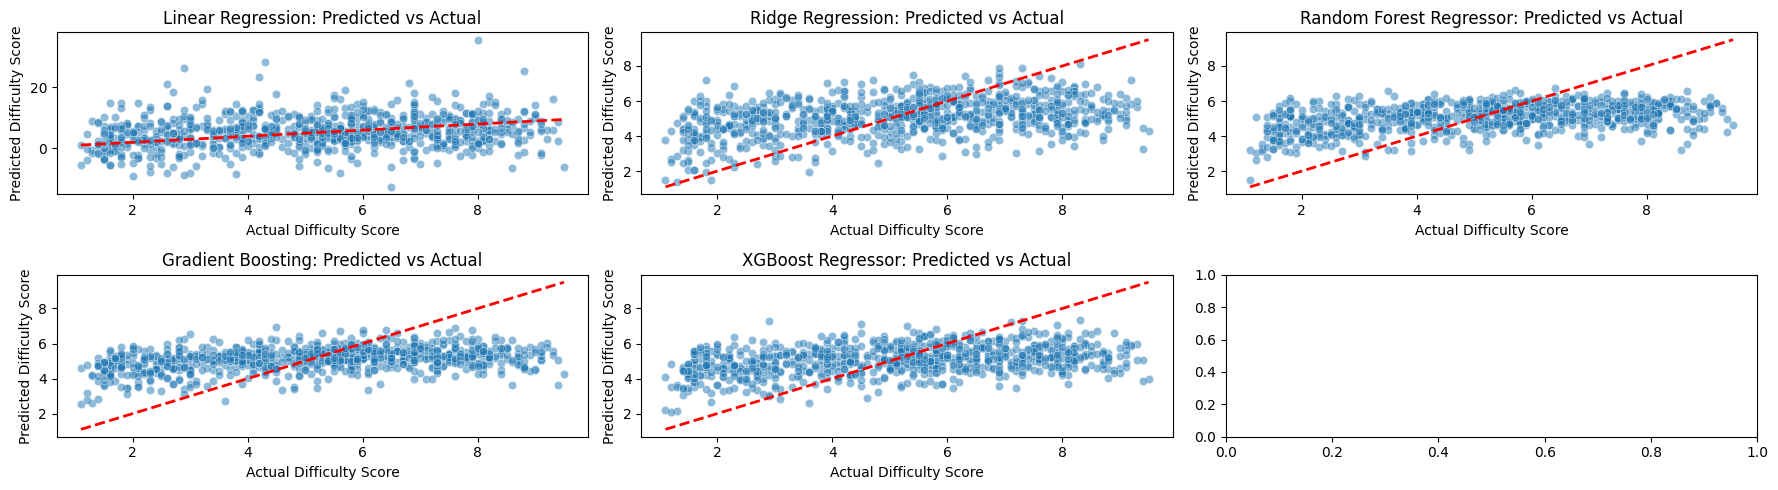

                     Model     MAE    RMSE
0        Linear Regression  3.9969  5.2832
1         Ridge Regression  1.6707  2.0325
2  Random Forest Regressor  1.6711  1.9945
3        Gradient Boosting  1.6996  2.0316
4        XGBoost Regressor  1.6932  2.0294


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Placeholder for results
results_list = []

# Set up the plotting area (1 row, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 5))
axes = axes.flatten()

for i, (name, model) in enumerate(regressors.items()):
    # 1. Fit the model
    model.fit(X_train, y_train_r)

    # 2. Generate predictions
    preds = model.predict(X_test)

    # 3. Calculate Metrics
    mae = mean_absolute_error(y_test_r, preds)
    rmse = np.sqrt(mean_squared_error(y_test_r, preds))

    results_list.append({
        "Model": name,
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4)
    })

    # 4. Plot Figure 5: Predicted vs Actual
    sns.scatterplot(x=y_test_r, y=preds, ax=axes[i], alpha=0.5)
    axes[i].plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2) # Diagonal line
    axes[i].set_title(f"{name}: Predicted vs Actual")
    axes[i].set_xlabel("Actual Difficulty Score")
    axes[i].set_ylabel("Predicted Difficulty Score")

plt.tight_layout()
plt.show()

# 5. Display Table 5
results_df = pd.DataFrame(results_list)
print(results_df)